In [2]:
from scipy.misc import comb
import math 
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error = 0.25)

0.034327507019042969

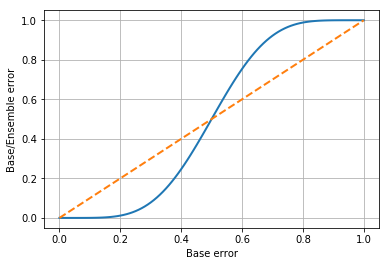

In [3]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.grid()
plt.show()

In [7]:
ex = np.array([[0.9, 0.1], 
              [0.8, 0.2], 
              [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])

In [8]:
p

np.argmax(p)

0

In [9]:
p


array([ 0.58,  0.42])

In [41]:
# majority vote classifier
# aka stacking
# generally used with  a logistic regression model that predicts the final class label 
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators 
import numpy as np 
import operator 


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble
      
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on 
        the argmax of class labels. Else if 
        'probability', the argmax of the sum of 
        probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are 
        provided, the classifiers are weighted by 
        importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers 
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
        
    def fit(self, x, y):
        """ Fit classifiers. 
        
        Parameters
        ----------
        x : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        -------
        self : object
    
        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # class in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(x, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self 

    def predict(self, x):
        """ Predict class labels for x. 
        
        Parameters
        ----------
        x : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples 
            
        Returns
        -------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels. 
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis = 1) 
            
        else: # 'classlabel' vote
            
            # Collect results from clf.predict calls 
            predictions = np.asarray([clf.predict(x) for clf in self.classifiers_]).T
            
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote
        
        
    def predict_proba(self, x):
        """Predict class probabilities for x. 
        
        Parameters
        ----------
        x : {array-like, sparse matrix}, 
            shape = [n_samples, n_features]
            Training vectors, where n_samples is 
            the number of samples and 
            n_features is the number of  features.
            
        Returns
        ---------
        avg_proba : array-like, 
            shape = [n_samples, n_classes]
            Weighted average probability for 
            each class per sample.
            
        """
        probas = np.asarray([clf.predict_proba(x) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """Get classifier parametr names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s_%s' % (name, key)] = value 
            return out
        


In [42]:
from sklearn import datasets 
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
x, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)



In [43]:
# split the iris samples into 50 percent training and 50 percent test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)



In [44]:
# train the three different classifiers 
# logisitic regression
# decision tree 
# k-nearest neighbors 

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    

10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [45]:
# combining the classifiers together 


In [46]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, scoring='roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


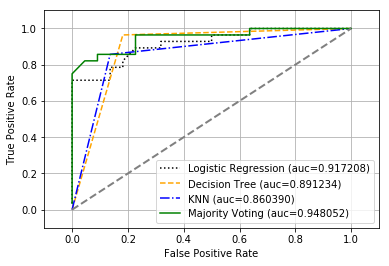

In [47]:
#  EVALUATING AND TUNING THE ENSEMBLE CLASSIFIER 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1 
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%02f)' % (label, roc_auc))

    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show() 

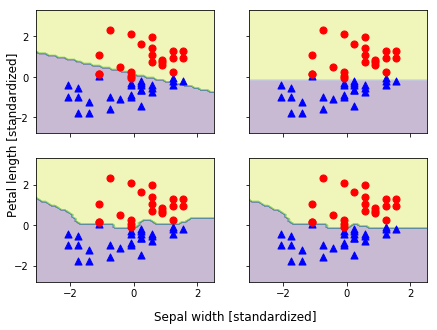

In [48]:
# standardizing the training set so that the decision regions of the decision tree will be on the same scale for visual 
# purposes

sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
from itertools import product
x_min = x_train_std[:, 0].min() - 1
x_max = x_train_std[:, 0].max() + 1
y_min = x_train_std[:, 1].min() - 1 
y_max = x_train_std[:, 1].max() + 1 
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(x_train_std, y_train)
    z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train==0, 0], x_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train==1, 0], x_train_std[y_train==1, 1], c='red', marker='o', s=50)
    
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)

plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)


plt.show()

In [49]:
# how to know how to access each individual classifier's attributes 
mv_clf.get_params()



{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier_class_weight': None,
 'decisiontreeclassifier_criterion': 'entropy',
 'decisiontreeclassifier_max_depth': 1,
 'decisiontreeclassifier_max_features': None,
 'decisiontreeclassifier_max_leaf_nodes': None,
 'decisiontreeclassifier_min_impurity_split': 1e-07,
 'decisiontreeclassifier_min_samples_leaf': 1,
 'decisiontreeclassifier_min_samples_split': 2,
 'decisiontreeclassifier_min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier_presort': False,
 'decisiontreeclassifier_random_state': 0,
 'decisiontreeclassifier_splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], 

In [50]:
# tuning the inverse regularization parameter of C of the Logistic Regression Classifier and the decision tree
# depth 
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [51]:
# printing the average hyperparameter combinations and the avg ROC AUC scores via 10-fold cross-validation 
for params, mean_score, scores in grid.grid_scores_: 
    print("%0.3f +/- %0.2f %r" % (mean_score, scores.std() / 2, params))
    

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [52]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [53]:
print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


In [54]:
# Bagging - building an ensemble of classifiers from bootstrap samples
# draws random samples with replacement from the initial training set
# aka bootstrap aggregating
# classifier => generally an unpruned decision tree 
# related to the random forest classifier 
# improves the accuracy of unstable models and decrease the degree of overfitting

In [56]:
# more complex classification problem
# wine dataset features: Alcohol and hue
import pandas as pd 
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns=['Class label', 'Alcohol', 
                 'Malic acid', 'Ash', 
                 'Alcalinity of ash', 
                 'Magnesium', 'Total phenols',
                 'Flavanoids', 'Nonflavanoid phenols',
                 'Proanthocyanins', 
                 'Color intensity', 'Hue', 
                 'OD280/OD315 of diluted wines', 
                 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
x = df_wine[['Alcohol','Hue']].values

In [57]:
 # enconding the class labels into binary format and split the dataset into 60% training and 40% test set 
from sklearn.preprocessing import LabelEncoder 
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=1)



In [58]:
# importing the baggiing classifier from scikit-learn
# unpruned decision tree
# create an ensemble of 500 decision trees fitted on diff bootstrap samples 

from sklearn.ensemble import BaggingClassifier 
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, 
                       bootstrap_features=False, n_jobs=1, random_state=1)


In [59]:
# calculating the accuracy of the prediction on the training and test dataset 
# comparing of the bagging classifier to the performance of a single unpruned tree
from sklearn.metrics import accuracy_score
tree = tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [60]:
# the low test accuracy => high variance(overfitting)

bag = bag.fit(x_train, y_train)
y_train_pred = bag.predict(x_train)
y_test_pred = bag.predict(x_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


In [62]:
# comparing the decision tree and the bagging classifier regions 
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(x_train, y_train)
    
    z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z=z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train==0, 0], x_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].set_title(tt)
    

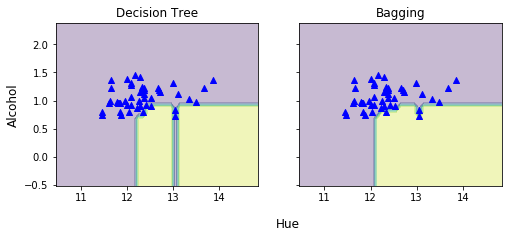

In [63]:
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

In [64]:
# bagging algorithm can be an effective approach to reduce the variance of the model
# bagging is ineffective in reducing model bias
# which is why it's important to choose an ensemble of classifiers with low bias



In [66]:
# LEVARAGING WEAK LEARNERS VIA ADAPTIVE BOOSTING
# focus on training samples that are hard to classify 
# let the weak learners learn from misclassified training samples 



In [68]:
# Generally have a high variance => overfitting the training data 
# adaboost 
# 500 decision tree stumps 
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)
tree = tree.fit(x_train, y_train)
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [69]:
ada = ada.fit(x_train, y_train)
y_train_pred = ada.predict(x_train)
y_test_pred = ada.predict(x_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.833


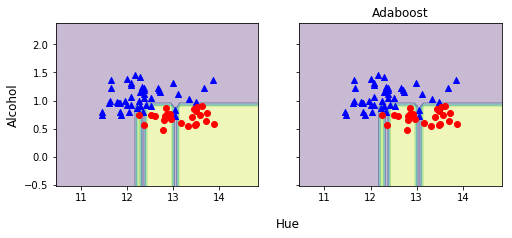

In [72]:
x_min = x_train[:, 0].min() - 1
x_max = x_train[:, 0].max() + 1 
y_min = x_train[:, 1].min() - 1
y_max = x_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

y, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8,3))


for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'Adaboost']):
    clf.fit(x_train, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, z, alpha=0.3)
    axarr[idx].scatter(x_train[y_train==0, 0], x_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(x_train[y_train==1, 0], x_train[y_train==1, 1], c='red', marker='o')
axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12)
plt.show()

In [ ]:
# adds a small amound of efficiency but adds a lot to the overhead,  hardly worth it...